In [1]:
from functools import reduce
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict
import torch
from torchvision import models
import numpy as np
from skimage import io
from pytorch_toolbelt.utils.rle import rle_decode
import albumentations as A
from albumentations.pytorch import ToTensorV2

from scripts.utils import annotation2mask, get_box
from scripts.dataset import CellDataset
from scripts.visualization import show_image

np.random.seed(0)

## Links to tutorials
- Torchvision maskrcnn inputting: [pytorch.org](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- Kaggle baseline notebook: [kaggle.com](https://www.kaggle.com/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273)


In [2]:
# Global config of dataset, not tunable parameters
config = EasyDict(
    dataset_path=Path("/data/kaggle_data/"),
    val_size=0.2,
    batch_size=2,
    num_workers=0,
)

In [3]:
# pascal_voc - inputting bbox coord in format (xmin, ymin, xmax, ymax)
valid_transform = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    A.ShiftScaleRotate(shift_limit=0.8, border_mode=cv2.BORDER_CONSTANT),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

/workspaces/sartorius_instance_segmentation/scripts/dataset.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  'masks': torch.as_tensor(masks),


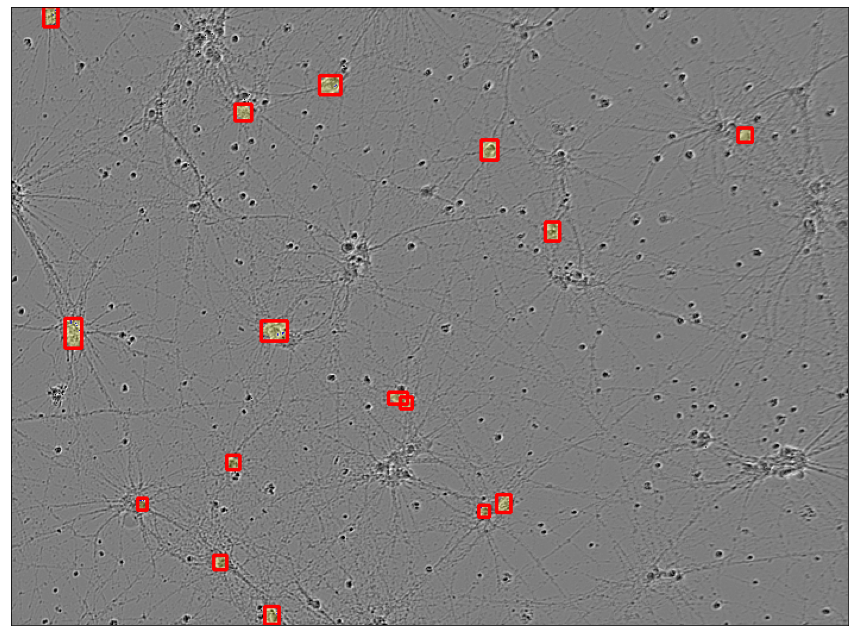

In [4]:
dataset = CellDataset(cfg=config, mode='train', transform=valid_transform)

image, data = dataset[1]
show_image(image, boxes=data['boxes'], masks=data['masks'])

In [5]:
# Do not change collate function - it was takes from torchvision tutorials
dataloader = DataLoader(dataset=CellDataset(cfg=config, mode='train', transform=valid_transform),
                        num_workers=config.num_workers,
                        batch_size=config.batch_size,
                        collate_fn=lambda x: tuple(zip(*x)))

# 2 classes: 0 - background, 1 - cell
model = models.detection.maskrcnn_resnet50_fpn(num_classes=2, progress=False)
model.train()

for image, label in dataloader:
    output = model(image, label)
    print(f"output: {output}")
    break

/conda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


output: {'loss_classifier': tensor(0.6662, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1191, grad_fn=<DivBackward0>), 'loss_mask': tensor(1.5798, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6926, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1621, dtype=torch.float64, grad_fn=<DivBackward0>)}
